In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
home_data = pd.read_csv('home_games.csv')
away_data = pd.read_csv('away_games.csv')

In [3]:
# Drop unused columns
home_data.drop(columns=["Unnamed: 2", "TOI", "CF%", "FF%", "SF%", "GF%", "xGF%", 
                        "SCF%", "HDCF%", "HDGF", "HDGA", "HDGF%", "HDSH%", "SH%", "HDSV%", "SV%", "PDO"], inplace=True)
away_data.drop(columns=["Unnamed: 2", "TOI", "CF%", "FF%", "SF%", "GF%", "xGF%",
                        "SCF%", "HDCF%", "HDGF", "HDGA", "HDGF%", "HDSH%", "SH%", "HDSV%", "SV%", "PDO"], inplace=True)

In [4]:
# Merge datasets, each row represents 1 game with advanced stats for both teams
merged_data = pd.merge(home_data, away_data, on='Game', suffixes=('_home', '_away'))

In [5]:
merged_data.columns

Index(['Game', 'Team_home', 'CF_home', 'CA_home', 'FF_home', 'FA_home',
       'SF_home', 'SA_home', 'GF_home', 'GA_home', 'xGF_home', 'xGA_home',
       'SCF_home', 'SCA_home', 'HDCF_home', 'HDCA_home', 'Team_away',
       'CF_away', 'CA_away', 'FF_away', 'FA_away', 'SF_away', 'SA_away',
       'GF_away', 'GA_away', 'xGF_away', 'xGA_away', 'SCF_away', 'SCA_away',
       'HDCF_away', 'HDCA_away'],
      dtype='object')

In [6]:
# Drop NA
merged_data.replace('-', pd.NA, inplace=True)
merged_data.dropna(inplace=True)

In [7]:
# Convert "Game" column to Date
merged_data["Game"] = merged_data["Game"].str.split(" - ").str[0]
merged_data.rename(columns={'Game': 'Date'}, inplace=True)
# Convert 'Date' column from string to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

In [8]:
merged_data

,Date,Team_home,CF_home,CA_home,FF_home,FA_home,SF_home,SA_home,GF_home,GA_home,...,SF_away,SA_away,GF_away,GA_away,xGF_away,xGA_away,SCF_away,SCA_away,HDCF_away,HDCA_away
0,2013-10-01,Montreal Canadiens,56,39,44,26,29,19,2,2,...,19,29,2,2,1.43,2.42,16,22,4,13
1,2013-10-01,Chicago Blackhawks,42,34,30,21,25,16,4,1,...,16,25,1,4,1.07,1.44,15,20,2,8
2,2013-10-01,Edmonton Oilers,48,39,30,31,23,21,2,4,...,21,23,4,2,2.64,1.54,24,22,13,6
3,2013-10-02,Philadelphia Flyers,44,33,29,26,17,21,0,2,...,21,17,2,0,1.16,1.56,14,20,5,8
4,2013-10-02,Detroit Red Wings,43,20,36,14,27,11,2,1,...,11,27,1,2,0.80,1.39,9,19,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,2024-03-19,Edmonton Oilers,37,49,20,32,17,20,2,1,...,20,17,1,2,1.88,1.43,20,16,7,7
13125,2024-03-19,Anaheim Ducks,36,33,27,26,21,19,0,3,...,19,21,3,0,1.28,1.33,15,10,3,6
13126,2024-03-19,Los Angeles Kings,42,51,32,32,23,18,5,1,...,18,23,1,5,1.29,2.36,22,22,6,13
13127,2024-03-19,Vancouver Canucks,41,40,30,22,20,11,1,0,...,11,20,0,1,1.03,3.38,13,28,3,16


In [9]:
# Function to calculate games in the last 4 days
def games_in_last_4_days(group):
    group = group.sort_values('Date')  # Ensure games are sorted by date
    count_list = []  # Store counts

    for i in range(len(group)):
        current_date = group.iloc[i]['Date']
        # Count games in the past 4 days INCLUDING the current game
        past_games = group[(group['Date'] > current_date - pd.Timedelta(days=4)) & 
                           (group['Date'] <= current_date)]
        count_list.append(len(past_games) - 1)  # Exclude current game itself

    group['Games in Last 4 Days'] = count_list
    return group

In [10]:
# Apply the function separately for home and away teams
merged_data = merged_data.groupby('Team_home', group_keys=False).apply(games_in_last_4_days)
merged_data.rename(columns={'Games in Last 4 Days': 'Games in Last 4 Days_home'}, inplace=True)

merged_data = merged_data.groupby('Team_away', group_keys=False).apply(games_in_last_4_days)
merged_data.rename(columns={'Games in Last 4 Days': 'Games in Last 4 Days_away'}, inplace=True)


In [11]:
# Calculate goals above expected for home and away teams
merged_data['Goals Above Expected_home'] = merged_data['GF_home'] - merged_data['xGF_home']
merged_data['Goals Above Expected_away'] = merged_data['GF_away'] - merged_data['xGF_away']

In [12]:
# Calculate rolling averages for home and away teams
def calculate_rolling_averages(group, window=3):
    group['Rolling Goals Above Expected_home'] = group['Goals Above Expected_home'].rolling(window=window, min_periods=1).sum()
    group['Rolling Goals Above Expected_away'] = group['Goals Above Expected_away'].rolling(window=window, min_periods=1).sum()
    
    return group

In [13]:
# Apply rolling averages to each home and away team
merged_data = merged_data.groupby('Team_home').apply(calculate_rolling_averages)
merged_data = merged_data.groupby('Team_away').apply(calculate_rolling_averages)

In [14]:
# Add rolling averages for goals scored and conceded (from earlier code)
merged_data['GF_avg_home'] = merged_data.groupby('Team_home')['GF_home'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
merged_data['GA_avg_home'] = merged_data.groupby('Team_home')['GA_home'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
merged_data['GF_avg_away'] = merged_data.groupby('Team_away')['GF_away'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
merged_data['GA_avg_away'] = merged_data.groupby('Team_away')['GA_away'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

In [15]:
merged_data.columns

Index(['Date', 'Team_home', 'CF_home', 'CA_home', 'FF_home', 'FA_home',
       'SF_home', 'SA_home', 'GF_home', 'GA_home', 'xGF_home', 'xGA_home',
       'SCF_home', 'SCA_home', 'HDCF_home', 'HDCA_home', 'Team_away',
       'CF_away', 'CA_away', 'FF_away', 'FA_away', 'SF_away', 'SA_away',
       'GF_away', 'GA_away', 'xGF_away', 'xGA_away', 'SCF_away', 'SCA_away',
       'HDCF_away', 'HDCA_away', 'Games in Last 4 Days_home',
       'Games in Last 4 Days_away', 'Goals Above Expected_home',
       'Goals Above Expected_away', 'Rolling Goals Above Expected_home',
       'Rolling Goals Above Expected_away', 'GF_avg_home', 'GA_avg_home',
       'GF_avg_away', 'GA_avg_away'],
      dtype='object')

In [16]:
# Define features and target
features = [
    # Home team stats
    'CF_home', 'CA_home', 'FF_home', 'FA_home', 'SF_home', 'SA_home',
    'xGF_home', 'xGA_home', 'SCF_home', 'SCA_home', 'HDCF_home', 'HDCA_home',
    
    # Away team stats
    'CF_away', 'CA_away', 'FF_away', 'FA_away', 'SF_away', 'SA_away',
    'xGF_away', 'xGA_away', 'SCF_away', 'SCA_away', 'HDCF_away', 'HDCA_away',
    
    # Rolling averages
    'GF_avg_home', 'GA_avg_home', 'GF_avg_away', 'GA_avg_away',
    
    # Goals above expected (rolling)
    'Rolling Goals Above Expected_home', 'Rolling Goals Above Expected_away',

    # Number of games in 4 day window
    'Games in Last 4 Days_home', 'Games in Last 4 Days_away'
]

target_home = 'GF_home'
target_away = 'GF_away'

In [17]:
X = merged_data[features]
y_home = merged_data[target_home]
y_away = merged_data[target_away]

In [18]:
# Split data
X_train, X_test, y_train_home, y_test_home, y_train_away, y_test_away = train_test_split(
    X, y_home, y_away, test_size=0.2, random_state=42
)

In [19]:
# Train model (example: Grid Search CV with Random Forest)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,  # Use all available CPU cores
    verbose=2   # Print progress updates
)
grid_search.fit(X_train, y_train_home)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Train model with best parameters
best_model_home = grid_search.best_estimator_
best_model_home.fit(X_train, y_train_home)

# Evaluate
y_pred_home = best_model_home.predict(X_test)
print("Home MAE (tuned):", mean_absolute_error(y_test_home, y_pred_home))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Home MAE (tuned): 0.838816074829266


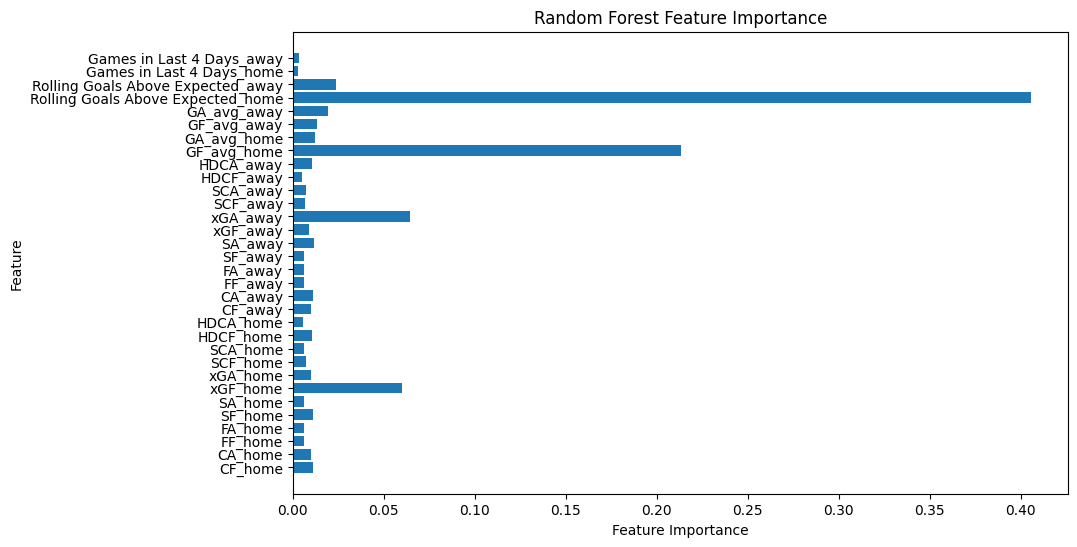

In [20]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model_home.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()